In [1]:
import sys
sys.path.append('../../code')
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
from sbi import inference as sbi_inference
from utils import (linear_scale_array, UniformPrior,
                   get_dataset_psd, get_dataset_peaks, load_posterior, simulator_hnn,
                   get_parameter_recovery, get_posterior_predictive_check, hnn_erp_param_function)
from hnn_core import jones_2009_model
from functools import partial
import dill
from sbi import utils as sbi_utils
import pandas as pd
from sklearn.decomposition import PCA
rng_seed = 123

scale_factor = 60_000

sns.set()
sns.set_style("white")

device = 'cpu'

sim_type = 'hnn_erp'
data_path = f'../../data/{sim_type}'

with open(f'{data_path}/posteriors/posterior_dicts.pkl', 'rb') as output_file:
    posterior_state_dicts = dill.load(output_file)
with open(f'{data_path}/sbi_sims/prior_dict.pkl', 'rb') as output_file:
    prior_dict = dill.load(output_file)
with open(f'{data_path}/sbi_sims/sim_metadata.pkl', 'rb') as output_file:
    sim_metadata = dill.load(output_file)
with open(f'{data_path}/posteriors/posterior_metadata.pkl', 'rb') as output_file:
    posterior_metadata = dill.load(output_file)
    
dt = sim_metadata['dt'] # Sampling interval used for simulation
tstop = sim_metadata['tstop'] # Sampling interval used for simulation
zero_samples = posterior_metadata['zero_samples'] 

net = jones_2009_model()

simulator = partial(simulator_hnn, prior_dict=prior_dict, param_function=hnn_erp_param_function,
                    network_model=net, tstop=tstop, return_objects=True)

/home/ntolley/anaconda3/envs/sbi/lib/python3.8/site-packages/dask_jobqueue/core.py:19: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/home/ntolley/anaconda3/envs/sbi/lib/python3.8/site-packages/dask_jobqueue/core.py:19: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/home/ntolley/anaconda3/envs/sbi/lib/python3.8/site-packages/dask_jobqueue/htcondor.py:6: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import parse_bytes


In [7]:
%matplotlib inline
# Values on [0,1] mapped to range of bounds defined in prior_dict
theta_cond_list = [np.array([0.65, 0.95, 0.65, 0.5]), np.array([0.15, 0.25, 0.45, 0.65])]


x_cond_list, theta_dict_list, net_list = list(), list(), list()
for theta_cond in theta_cond_list:
    theta_dict = {param_name: param_dict['rescale_function'](theta_cond[idx], param_dict['bounds']) for 
                  idx, (param_name, param_dict) in enumerate(prior_dict.items())}

    net, dpl = simulator(torch.tensor(theta_cond).float())[0]
    x_cond = dpl[0].copy().smooth(20).data['agg']
        
    theta_dict_list.append(theta_dict)
    x_cond_list.append(x_cond)
    net_list.append(net)



{'dist_inh': 0.07943279730825811, 'prox_inh': 5.011871510848892, 'dist_exc': 0.07943279730825811, 'prox_exc': 0.01}
joblib will run over 1 jobs
Building the NEURON model
[Done]
running trial 1 on 1 cores
Simulation time: 0.5 ms...
Simulation time: 10.0 ms...
Simulation time: 20.0 ms...
Simulation time: 30.0 ms...
Simulation time: 40.0 ms...
Simulation time: 50.0 ms...
Simulation time: 60.0 ms...
Simulation time: 70.0 ms...
Simulation time: 80.0 ms...
Simulation time: 90.0 ms...
Simulation time: 100.0 ms...
Simulation time: 110.0 ms...
Simulation time: 120.0 ms...
Simulation time: 130.0 ms...
Simulation time: 140.0 ms...
Simulation time: 150.0 ms...
Simulation time: 160.0 ms...
Simulation time: 170.0 ms...
Simulation time: 180.0 ms...
Simulation time: 190.0 ms...
Simulation time: 200.0 ms...
Simulation time: 210.0 ms...
Simulation time: 220.0 ms...
Simulation time: 230.0 ms...
Simulation time: 240.0 ms...
{'dist_inh': 7.943283001347201e-05, 'prox_inh': 0.00031622776601683794, 'dist_exc'

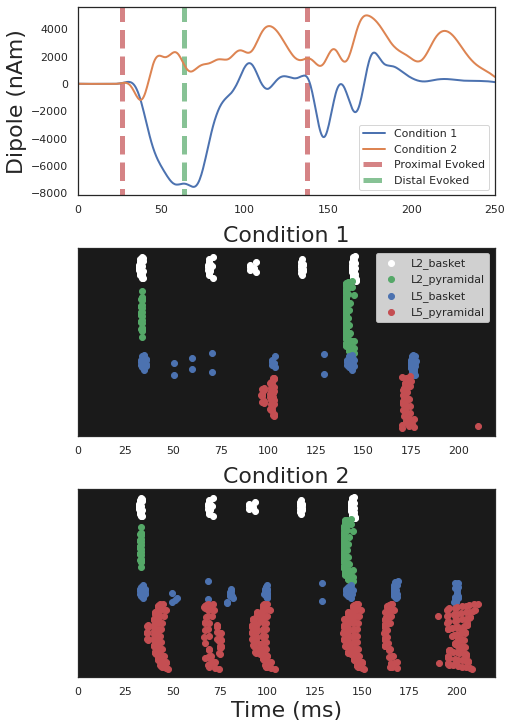

In [53]:
%matplotlib inline

erp_dist_times = [63.53]
erp_prox_times = [26.61, 137.12]

labelsize = 22
titlesize=22

offset_samples = 0

# Plot conditioning features    
t_vec = np.linspace(0, tstop, x_cond_list[0].squeeze().shape[0])

plot_t_vec = t_vec - t_vec[offset_samples]
time_lim = [0, plot_t_vec[-1]]

fig, axes = plt.subplots(3,1,figsize=(7,10), constrained_layout=True)
axes[0].plot(plot_t_vec, x_cond_list[0].squeeze() * scale_factor, linewidth=2, label='Condition 1')
axes[0].plot(plot_t_vec, x_cond_list[1].squeeze() * scale_factor, linewidth=2, label='Condition 2')
axes[0].set_xlabel('Time (ms)', fontsize=labelsize)
axes[0].set_xlim(time_lim)
axes[0].set_ylabel('Dipole (nAm)', fontsize=labelsize)
axes[0].set_ylim(axes[0].get_ylim())

axes[0].vlines(x=erp_prox_times, ymin=-1e10, ymax=1e10, color='C3',linewidth=5, linestyle='--', label='Proximal Evoked', alpha=0.7)
axes[0].vlines(x=erp_dist_times, ymin=-1e10, ymax=1e10, color='C2',linewidth=5, linestyle='--', label='Distal Evoked', alpha=0.7)
axes[0].legend()

net_list[0].cell_response.plot_spikes_raster(ax=axes[1], show=False)
net_list[1].cell_response.plot_spikes_raster(ax=axes[2], show=False)

axes[0].set_xlabel('')
#axes[0].set_xticklabels('')

axes[1].set_title('Condition 1', fontsize=titlesize)
axes[1].set_xlabel('')
#axes[1].set_xticklabels('')
axes[2].set_title('Condition 2', fontsize=titlesize)
axes[2].set_xlabel('Time (ms)', fontsize=labelsize)
axes[2].get_legend().remove()


plt.savefig('hnn_erp_cond_raster.svg')